# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [203]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyClassifier

RANDOM_STATE=12345

In [172]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('C:/Users/Home/Downloads/users_behavior.csv')

In [173]:
# сбор данных о датафрейме:
def data_info(data):
    print(f'''
    ----------------------------------------
    Первые строки датафрейма:
    ----------------------------------------''')
    display(data.head())
    print(f'''
    ----------------------------------------
    Последние строки датафрейма:
    ----------------------------------------''')
    display(data.tail())
    print(f'''
    ----------------------------------------
    Общая информация:
    ----------------------------------------''')
    print(data.info())
    print(f'''
    ----------------------------------------
    Дупликаты:
    ----------------------------------------''')
    print(data.duplicated().sum())
    print(f'''
    ----------------------------------------
    Пропуски:
    ----------------------------------------''')
    display(round(data.isna().sum(),))
    print(f'''
    ----------------------------------------
    И немного статистических данных:
    ----------------------------------------''')
    print(data.describe(include='all'))
    
    
def get_plot(model, train_list, valid_list, point, best_accuracy, xlabel='', bias=1):
    '''функция для отрисовки plt.plot'''
    
    plt.figure(figsize=(12, 5))
    plt.plot(train_list, label='train', c='aquamarine')
    plt.plot(valid_list, label='valid', c='gold')
    plt.scatter(point-bias, best_accuracy, c='#02F83A', s=50)
    plt.annotate(f'{best_accuracy=:.4f}', xy=(point, best_accuracy),
                 xytext=(-16, 10), textcoords='offset points', fontweight='bold')

    plt.legend(facecolor='oldlace', edgecolor='#7B6DA5', loc='center right')
    plt.title(f'модель {type(model).__name__}', fontweight='bold', fontsize=15,  fontname='Arial')
    plt.xlabel(xlabel)
    plt.ylabel('значение accuracy')
    plt.xticks(range(len(valid_list)), range(1, len(valid_list)+1), rotation=90)     
    plt.minorticks_on()
    plt.grid(which='major', linewidth=0.5)
    plt.grid(which='minor', axis='y', linewidth=0.25, linestyle='--')
    plt.show()
    
    
def get_roc_curve(y, y_pred):
    '''функция для подсчёта AUC и отрисовки ROC-кривой'''
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    # Вычисляем AUC
    auc = roc_auc_score(y, y_pred)
    # Строим ROC-кривую
    plt.figure(figsize=(11, 5))
    plt.plot(fpr, tpr, c='orange', label=f'AUC={auc:.3f}')
    plt.plot([0, 1], [0, 1], '--', color='#2C3E50')
    plt.xlabel('FPR - False Positive Rate')
    plt.ylabel('TPR - True Positive Rate')
    plt.title('ROC-кривая', fontweight='bold', fontsize=15,  fontname='Arial')
    plt.legend()
    plt.grid(linewidth=0.25, linestyle='--')
    plt.show()

In [174]:
data_info(df)


    ----------------------------------------
    Первые строки датафрейма:
    ----------------------------------------


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0



    ----------------------------------------
    Последние строки датафрейма:
    ----------------------------------------


,calls,minutes,messages,mb_used,is_ultra
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0
3213,80.0,566.09,6.0,29480.52,1



    ----------------------------------------
    Общая информация:
    ----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None

    ----------------------------------------
    Дупликаты:
    ----------------------------------------
0

    ----------------------------------------
    Пропуски:
    ----------------------------------------


calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64


    ----------------------------------------
    И немного статистических данных:
    ----------------------------------------
             calls      minutes     messages       mb_used     is_ultra
count  3214.000000  3214.000000  3214.000000   3214.000000  3214.000000
mean     63.038892   438.208787    38.281269  17207.673836     0.306472
std      33.236368   234.569872    36.148326   7570.968246     0.461100
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%      40.000000   274.575000     9.000000  12491.902500     0.000000
50%      62.000000   430.600000    30.000000  16943.235000     0.000000
75%      82.000000   571.927500    57.000000  21424.700000     1.000000
max     244.000000  1632.060000   224.000000  49745.730000     1.000000


В таблице у нас 5 колонок:

- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

По первому взгляду можно сказать, что среди людей, у которых уже есть тариф "Ультра", по сравнению с остальными пользователями, использование интернета значительно меньшее, нежели у остальных пользователей.

Также на всякий случай, проверила на пропуски - русское *авось* - великое дело.

Все колонки в таблице того типа, которого нужно. Ну, по крайней мере почти все - я не уверена, нужно ли изменять тип колонка 'is_ultra' на bool или float.

Также мы видим, что у нас совершенно разного диапазона данные, так что нужно будет масштабировать.

## Разбейте данные на выборки

Первоначально, определим обучающий набор данных и целевой признак. В нашем случае - целевым признаком будет являться колонка *'is_ultra'*

In [189]:
features = df.drop(['is_ultra'],axis=1)
target = df['is_ultra']

Далее делим данные на 2 группы - обучающий набор и целевой признак и на временные набор и целевой признак.

In [190]:
features_train, features_tmp, target_train, target_tmp = train_test_split(features, target,
                                                                          test_size = 0.4, random_state=RANDOM_STATE)

Также, нам понадобится валидационная выборка:

In [191]:
features_valid, features_test, target_valid, target_test = train_test_split(features_tmp, target_tmp,
                                                                           test_size= 0.5, random_state=RANDOM_STATE)

В итоге получаем 3 выборки в соотношении 4:1 : обучающую и валидационную

In [192]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(1928, 4)
(643, 4)
(643, 4)


In [193]:
scaler = RobustScaler()
features_train = scaler.fit_transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

## Исследуйте модели

Для исследования нам необходима модель классификации. У нас их существует много видов, но мы изучили 3 из них - *решающее дерево, случайный лес и логистическая регрессия.*

Решающее дерево:

In [194]:
best_model_d, best_accuracy_d = 0, 0
splitters = ['best','random']
criteries = ['gini','entropy']

# мы будем проверять модель на обучающей и валидационной выборках, изменяя гиперпараметры моделей, и выведем лучшую:
for depth in range(1,51): 
    for criter in criteries:
        for split in splitters:
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, splitter=split, criterion=criter)
            model.fit(features_train, target_train)
            valid_score = accuracy_score(target_valid, model.predict(features_valid))
            if valid_score > best_accuracy_d:
                best_model_d = model
                best_accuracy_d = valid_score
    
    
print(f'''Лучшая модель: {best_model_d}; 
Лучшee accuracy: {best_accuracy_d}.''')

Лучшая модель: DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=12345,
                       splitter='random'); 
Лучшee accuracy: 0.7884914463452566.


Таким образом, у нас лучшая модель среди решающих деревьев - с критерием `gini`, максимальной глубиной `11` и с `splitter='random'`.

Случайный лес:

In [195]:
best_model_r, best_accuracy_r = 0, 0
criteries = ['gini','entropy']

for est in range(1, 51):
    for criter in criteries:
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, criterion=criter)
        model.fit(features_train, target_train) 
        valid_score = accuracy_score(target_valid, model.predict(features_valid))
        if valid_score > best_accuracy_r:
            best_model_r = model
            best_accuracy_r = valid_score
        
print(f'''Лучшая модель: {best_model_r}; 
Лучшee accuracy: {best_accuracy_r}.''')

Лучшая модель: RandomForestClassifier(criterion='entropy', n_estimators=32, random_state=12345); 
Лучшee accuracy: 0.7962674961119751.


Логистическая регрессия:

In [196]:
best_model_l, best_accuracy_l = 0, 0
solvers = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']

for it in range(1, 51, 10):
    for solver in solvers:
        model = LogisticRegression(random_state=RANDOM_STATE, solver=solver, max_iter=it)
        model.fit(features_train, target_train) 
        valid_score = accuracy_score(target_valid, model.predict(features_valid))
        if valid_score > best_accuracy_l:
            best_model_l = model 
            best_accuracy_l = valid_score
        
print(f'''Лучшая модель: {best_model_l}; 
Лучшee accuracy: {best_accuracy_l}.''')

Лучшая модель: LogisticRegression(max_iter=1, random_state=12345, solver='newton-cg'); 
Лучшee accuracy: 0.76049766718507.


Метод ближайших соседей:

In [197]:
best_model_k, best_accuracy_k = 0, 0
neigh = [5, 10, 15, 50, 100]
weights = ['uniform','distance']

for n in neigh:
    for weight in weights:
        model = KNeighborsClassifier(n_neighbors=n, weights=weight)
        model.fit(features_train, target_train)
        valid_score = accuracy_score(target_valid, model.predict(features_valid))
        if valid_score > best_accuracy_k:
            best_model_k = model
            best_accuracy_k = valid_score

            
print(f'''Лучшая модель: {best_model_k}; 
Лучшee accuracy: {best_accuracy_k}.''')            

Лучшая модель: KNeighborsClassifier(n_neighbors=50, weights='distance'); 
Лучшee accuracy: 0.7931570762052877.


Градиентный бустинг:

In [204]:
best_model_g, best_accuracy_g = 0, 0
n_est = [5, 10, 50, 100, 500]
rates = [0.1, 1, 10]
depths = [10, 50, 100]

for est in n_est:
    for rate in rates:
        for depth in depths:
            model = GradientBoostingClassifier(n_estimators=est, learning_rate=rate, max_depth=depth, random_state=RANDOM_STATE)
            model.fit(features_train, target_train)
            valid_score = accuracy_score(target_valid, model.predict(features_valid))
            if valid_score > best_accuracy_g:
                best_model_g = model
                best_accuracy_g = valid_score

            
print(f'''Лучшая модель: {best_model_g}; 
Лучшee accuracy: {best_accuracy_g}.''')     

Лучшая модель: GradientBoostingClassifier(max_depth=10, random_state=12345); 
Лучшee accuracy: 0.7822706065318819.


Исходя из проведенных подбора гиперпараметров разных моделей, *рандомный лес* показал себя наилучшим образом среди всех моделей.

## Проверьте модель на тестовой выборке

Проверим модели на тестовой выборке:

In [205]:
models = [best_model_d, best_model_r, best_model_l, best_model_k, best_model_g]

for model in models:
    answers = model.predict(features_test)
    f1 = f1_score(target_test, answers)
    recall = recall_score(target_test, answers)
    precision = precision_score(target_test, answers)
    print(f'''-------------
    {model}:
    - accuracy: {accuracy_score(target_test, answers)}
    - precision: {precision}; 
    - recall: {recall};
    - f1_score: {f1}.''')

-------------
    DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=12345,
                       splitter='random'):
    - accuracy: 0.7900466562986003
    - precision: 0.788135593220339; 
    - recall: 0.458128078817734;
    - f1_score: 0.5794392523364486.
-------------
    RandomForestClassifier(criterion='entropy', n_estimators=32, random_state=12345):
    - accuracy: 0.7947122861586314
    - precision: 0.7261146496815286; 
    - recall: 0.5615763546798029;
    - f1_score: 0.6333333333333333.
-------------
    LogisticRegression(max_iter=1, random_state=12345, solver='newton-cg'):
    - accuracy: 0.7527216174183515
    - precision: 0.782051282051282; 
    - recall: 0.30049261083743845;
    - f1_score: 0.43416370106761565.
-------------
    KNeighborsClassifier(n_neighbors=50, weights='distance'):
    - accuracy: 0.7853810264385692
    - precision: 0.7981651376146789; 
    - recall: 0.42857142857142855;
    - f1_score: 0.5576923076923077.
-------------
    Gradie

Все метрики неплохо себя показали - точность выше 75%. Лучше всех - `RandomForest`. Учитывая дисбаланс классов, опираться все таки лучше на метрики `precision, recall и f1_score`.

## Проверка на адекватность

У всех моделей относительно сравнимая друг с другом точность, однако в целом полнота ответов сильно разнится - и наиболее точно предсказывают *соседи*, из чего можно делать вывод, что это наиболее точная модель из всех. Однако, у нас наглядно демонстрируется дисбаланс классов:

In [199]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

То есть, если мы просто будем предсказывать `0`, то у нас получится модель вот с такой accuracy:

In [200]:
(df['is_ultra'].value_counts()[0]/df.shape[0])*100

69.35283136278781

У нас, однако, точность такая:

In [206]:
best_accuracy_r*100

79.62674961119751

Собственно, вот так наглядно наша модель отличает классы:

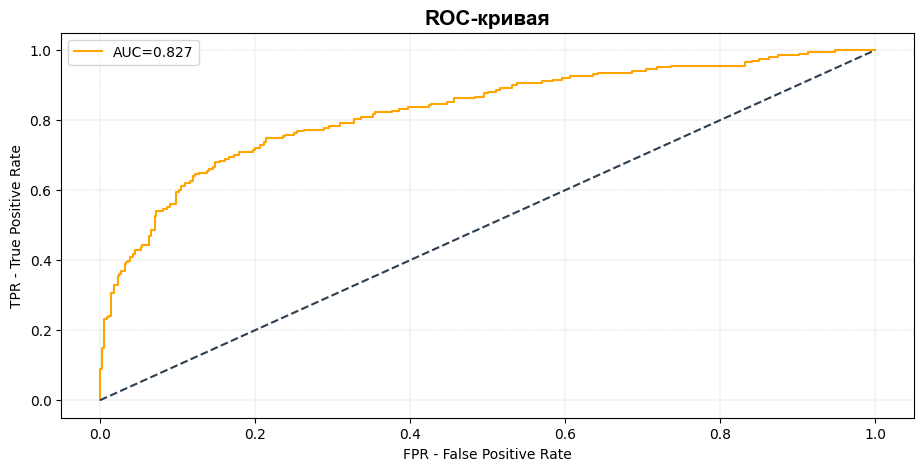

In [207]:
get_roc_curve(target_test, best_model_k.predict_proba(features_test)[:,1])

Чем больше график модели захватывает левый верхний угол - тем лучше - это значит, что модель прекрасно научилась определять классы. Черным цветом нарисована модель, которая предсказывает рандомно 0 или 1 - ее AUC (area inder curve) = 0.5. У нашей - 0.827 (лучше всего - AUC=1, так что нам еще есть куда расти, но уже достаточно неплохо)

# Подведем итоги

Мы ставили задачей определить и построить модель, решающую задачу классификации для подбора подходящего тарифа по имеющимся у нас данным. Первым делом мы (конечно, на всякий случай) проверили, все ли в порядке с данными, а также масштабировали, ибо они (*данные*), были у нас в совершенно разных диапазонах, а следовательно, это могло достаточно сильно повлиять на результат работы разных моделей.

Мы протестировали:
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier
- K-Neighbors Classifier
- GradientBoostingClassifier

А также, смотрели не только на `accuracy` (которая при дисбалансе классов не самая лучшая из метрик), но и на:
- precision
- recall
- f1
- roc-auc

После проведенного исследования получили, что `RandomForest` отработала лучше всего, и эта модель достаточно нейтральна к дисбалансу классов, однако, необходимо следить за переобучением модели и вовремя остановиться.

Чтобы не обращать внимание на этот нюанс можно использовать механизм градиентного бустинга - показатели там не сильно отличаются, однако расходуемые ресурсы компьютера и риск переообучения будет меньше за счет алгоритма работы.